Training Logistic Regression (grid search)...


/tmp/ipython-input-698511756.py:93: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df_std[c].dtype != np.number:


Best LR params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best LR CV ROC-AUC: 0.8907925407925408

Training Random Forest (grid search)...
Best RF params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
Best RF CV ROC-AUC: 0.8971898471898472

=== Logistic Regression Test Metrics ===
Accuracy : 0.852
F1-Score : 0.873
ROC-AUC  : 0.898
PR-AUC   : 0.914

Confusion Matrix:
 [[21  7]
 [ 2 31]]

Classification Report:
               precision    recall  f1-score   support

           0      0.913     0.750     0.824        28
           1      0.816     0.939     0.873        33

    accuracy                          0.852        61
   macro avg      0.864     0.845     0.848        61
weighted avg      0.860     0.852     0.850        61



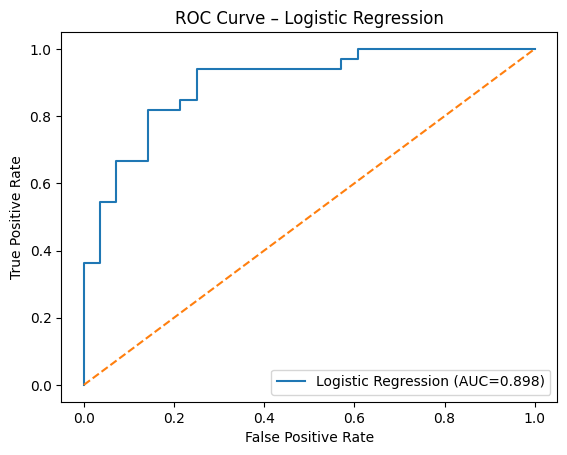

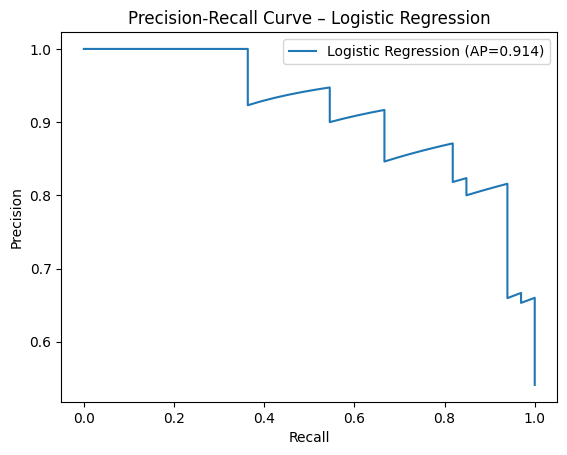


=== Random Forest Test Metrics ===
Accuracy : 0.770
F1-Score : 0.806
ROC-AUC  : 0.899
PR-AUC   : 0.918

Confusion Matrix:
 [[18 10]
 [ 4 29]]

Classification Report:
               precision    recall  f1-score   support

           0      0.818     0.643     0.720        28
           1      0.744     0.879     0.806        33

    accuracy                          0.770        61
   macro avg      0.781     0.761     0.763        61
weighted avg      0.778     0.770     0.766        61



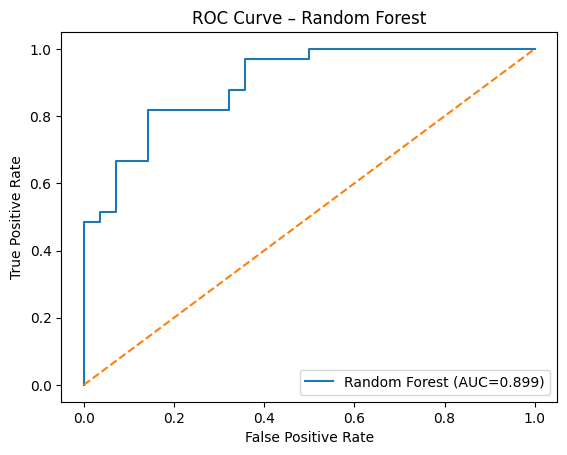

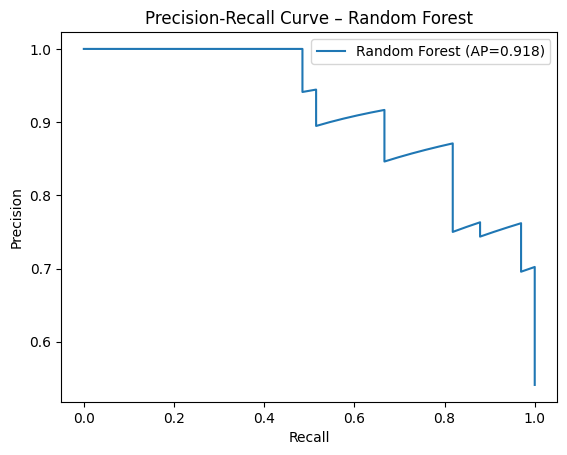


Cross-validated ROC-AUC:
Logistic Regression: mean=0.904 ± 0.048
Random Forest      : mean=0.908 ± 0.045

Top 15 Feature Importances (Random Forest):
cp_0         0.119414
thal_2       0.118424
oldpeak      0.093075
thalach      0.086332
thal_3       0.081737
ca           0.080453
chol         0.061854
age          0.060200
exang        0.058474
trestbps     0.052171
slope_2      0.047462
cp_2         0.033720
slope_1      0.027544
sex          0.020371
restecg_1    0.015453
dtype: float64


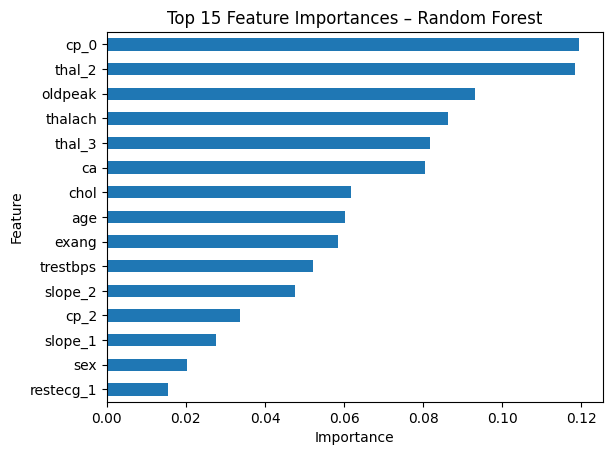

In [1]:
# Heart Attack (Heart Disease) Prediction – End-to-end ML Pipeline
# ---------------------------------------------------------------
# - Loads a standard heart-disease dataset (e.g., Kaggle "heart.csv")
# - Cleans/encodes features with a robust sklearn Pipeline
# - Trains Logistic Regression and Random Forest (with tuning)
# - Evaluates with accuracy, F1, ROC-AUC, PR-AUC, and plots curves
# ---------------------------------------------------------------

# 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_recall_curve,
    roc_curve, confusion_matrix, classification_report, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 2) Config: path to your dataset
#    Place heart.csv in your working directory (e.g., upload to Colab or your project folder)
CSV_PATH = "/content/heart.csv"   # change if needed

# 3) Load data
df = pd.read_csv(CSV_PATH)

# Optional: standardize column names (lowercase, no spaces)
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace("-", "_")
)

# 4) Map common alternative column names to a standard schema
#    Update this if your file differs.
expected_cols_map = {
    "age": ["age"],
    "sex": ["sex"],
    "cp": ["cp", "chest_pain_type"],
    "trestbps": ["trestbps", "resting_bp_s"],
    "chol": ["chol", "cholesterol"],
    "fbs": ["fbs", "fasting_bs"],
    "restecg": ["restecg", "resting_ecg"],
    "thalach": ["thalach", "max_hr", "max_heart_rate_achieved"],
    "exang": ["exang", "exercise_angina"],
    "oldpeak": ["oldpeak", "oldpeak_st_depression"],
    "slope": ["slope", "st_slope"],
    "ca": ["ca", "num_major_vessels"],
    "thal": ["thal", "thalassemia"],
    "target": ["target", "output", "condition", "heart_disease"]
}

# Build a mapping from actual columns to expected names
col_map = {}
for std, alts in expected_cols_map.items():
    found = None
    for c in df.columns:
        if c in alts:
            found = c
            break
    if found is None:
        raise ValueError(f"Missing required column for '{std}'. "
                         f"Expected one of {alts}, but not found in {list(df.columns)}.")
    col_map[std] = found

# 5) Select and rename to standard schema
df_std = df[[col_map[k] for k in expected_cols_map.keys()]].copy()
df_std.columns = list(expected_cols_map.keys())

# 6) Basic cleaning:
#    Some sources use '?' for missing in 'ca' and 'thal'
for c in ["ca", "thal"]:
    if df_std[c].dtype == object:
        df_std[c] = df_std[c].replace("?", np.nan)

# Convert numeric-like to numeric
num_convert = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
for c in num_convert:
    df_std[c] = pd.to_numeric(df_std[c], errors="coerce")

# Ensure binary/categorical are integers/strings as appropriate
# sex: 1=male, 0=female (typical for Kaggle heart.csv)
# fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
# exang: exercise-induced angina (1 = yes; 0 = no)
for c in ["sex", "fbs", "exang"]:
    if df_std[c].dtype != np.number:
        df_std[c] = pd.to_numeric(df_std[c], errors="coerce")

# For thal/slope/cp/restecg we will treat them as categorical (string) to be one-hot encoded robustly
categorical_cols = ["cp", "restecg", "slope", "thal"]
for c in categorical_cols:
    df_std[c] = df_std[c].astype("category").astype(str)

# 7) Define features/target
X = df_std.drop(columns=["target"])
y = df_std["target"].copy()

# Some datasets have target as {0,1}, others {0,1,2,3,4} etc.
# If target not binary, try to binarize: 1 if >0 else 0 (common in some UCI variants)
if y.nunique() > 2:
    y = (y.astype(float) > 0).astype(int)

# 8) Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 9) Feature groups for preprocessing
numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca", "sex", "fbs", "exang"]
# Keep categorical_cols defined above

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# 10) Models
log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None))
])

rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

# 11) Hyperparameter grids (small but sensible)
param_grid_lr = {
    "clf__C": [0.1, 1.0, 3.0, 10.0],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "liblinear"]
}

param_grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 12) Grid search for both models
gs_lr = GridSearchCV(log_reg, param_grid_lr, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0)
gs_rf = GridSearchCV(rf, param_grid_rf, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0)

print("Training Logistic Regression (grid search)...")
gs_lr.fit(X_train, y_train)
print("Best LR params:", gs_lr.best_params_)
print("Best LR CV ROC-AUC:", gs_lr.best_score_)

print("\nTraining Random Forest (grid search)...")
gs_rf.fit(X_train, y_train)
print("Best RF params:", gs_rf.best_params_)
print("Best RF CV ROC-AUC:", gs_rf.best_score_)

# 13) Evaluate best models on test set
def evaluate(model, X_test, y_test, label="Model"):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    ap  = average_precision_score(y_test, y_proba)

    print(f"\n=== {label} Test Metrics ===")
    print("Accuracy :", f"{acc:.3f}")
    print("F1-Score :", f"{f1:.3f}")
    print("ROC-AUC  :", f"{roc:.3f}")
    print("PR-AUC   :", f"{ap:.3f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {label}")
    plt.legend()
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision, label=f"{label} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve – {label}")
    plt.legend()
    plt.show()

# Evaluate
best_lr = gs_lr.best_estimator_
best_rf = gs_rf.best_estimator_

evaluate(best_lr, X_test, y_test, label="Logistic Regression")
evaluate(best_rf, X_test, y_test, label="Random Forest")

# 14) (Optional) Cross-validated comparison (ROC-AUC)
lr_cv = cross_val_score(best_lr, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
rf_cv = cross_val_score(best_rf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print("\nCross-validated ROC-AUC:")
print(f"Logistic Regression: mean={lr_cv.mean():.3f} ± {lr_cv.std():.3f}")
print(f"Random Forest      : mean={rf_cv.mean():.3f} ± {rf_cv.std():.3f}")

# 15) Feature importances (from RF) – using transformed feature names
def get_feature_names(preprocessor, categorical_cols, numeric_cols):
    # Numeric names
    num_features = numeric_cols

    # Categorical names after one-hot
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_features = ohe.get_feature_names_out(categorical_cols).tolist()
    return num_features + cat_features

rf_clf = best_rf.named_steps["clf"]
feature_names = get_feature_names(best_rf.named_steps["preprocess"], categorical_cols, numeric_cols)

importances = pd.Series(rf_clf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop 15 Feature Importances (Random Forest):")
print(importances.head(15))

plt.figure()
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances – Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
